In [4]:
%matplotlib inline


In [5]:
%pip install transformers[sentencepiece]


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW,

In [29]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import sklearn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [32]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
     

device(type='cpu')

In [15]:
df=pd.read_csv("IMDB Dataset.csv")
df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [63]:
def feel2num(value):
    if value=='positive': 
        return 0
    else: 
        return 1
    
df['sentiment']  =  df.sentiment.apply(feel2num)

     


Text(0.5, 0, 'Sentiment')

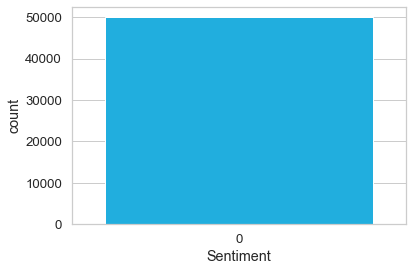

In [64]:

sns.countplot(df.sentiment)
plt.xlabel('Sentiment')
     

In [21]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [22]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note: encode_plus adds separators and classifiers with padding which are useful for classification

In [38]:
encoding = tokenizer.encode_plus(
 df.iloc[0]['review'],
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

encoding.keys()

c:\Users\Ioana\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

C:\Users\Ioana\AppData\Local\Temp/ipykernel_5344/3879956964.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


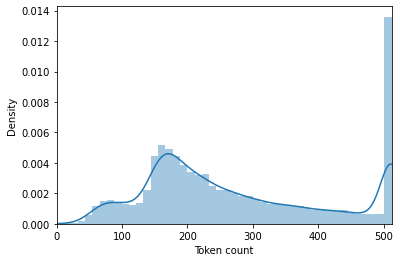

In [25]:
token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))
     

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');
     


In [41]:
MAX_LEN = 512

In [42]:
class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [59]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [60]:
df_train.shape, df_val.shape, df_test.shape

((40000, 2), (5000, 2), (5000, 2))

In [65]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MovieReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [67]:
BATCH_SIZE = 25

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
     


In [68]:
data = next(iter(train_data_loader))
data.keys()

In [90]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

100%|██████████| 20000/20000 [02:00<00:00, 165.87it/s]


# Sentiment analysis

In [ ]:


bert_model = BertModel.from_pretrained('bert-base-cased')
    

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)


Epoch 1/2
